In [1]:
import importlib
import os.path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import MinMaxScaler
import json
import pmdarima as pm
import sys
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import pylab
from typing import Tuple
import os


sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

from kad.visualization import visualization

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


# Reading data

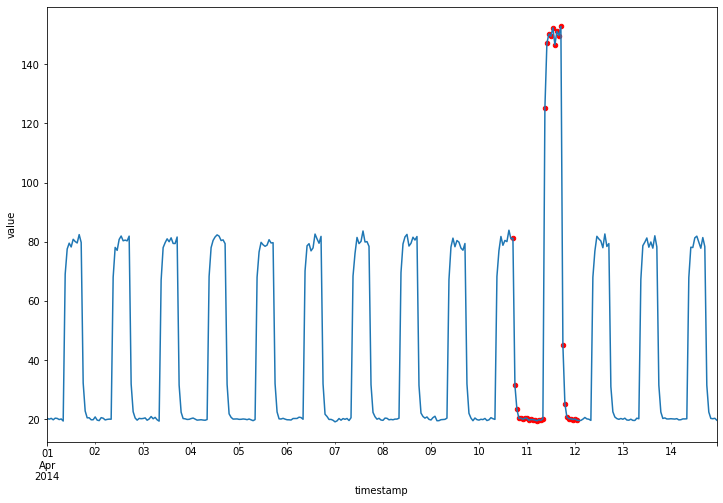

In [6]:
file = "artificialWithAnomaly/art_daily_jumpsup.csv"

daily_jumpsup_csv_path = os.path.join("data/archive/artificialWithAnomaly/", file)

original_df = pd.read_csv(
    daily_jumpsup_csv_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

true_anomalies_ranges = true_anomalies[file]

original_df_subset = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    original_df_subset = original_df_subset.append(original_df.loc[anom_range[0]:anom_range[1]])

with_anomalies_df = original_df.copy()
with_anomalies_df["is_anomaly"] = [idx in original_df_subset.index  for idx in original_df.index.tolist()]

visualization = importlib.reload(visualization)
visualization.visualize(resulting_df=with_anomalies_df, metric_name="value")